# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import *


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/AllDataCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()


# Global Params

In [3]:
# Global Flags
pcaFlag = True
fitPredFlag = True

# Choose clutering model
clusterModel = KMeans(n_clusters=5) #pred, PCA
# clusterModel = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average') #fitPred, PCA
# clusterModel = SpectralClustering(n_clusters=5, assign_labels='discretize') #fitPred, PCA
# clusterModel = Birch(n_clusters=5) #basically mini batch kmeans, pred, PCA

hemoModelName = 'Cluster_AC_Hemo'
allDataModelName = 'Cluster_AC_AllData'

# Group All Data Together

In [4]:
hemoOrig = escapeHemo.append(cardShockHemo)
hemoOrig

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PP,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,28.0,0.245614,0.428571,5357.575758,0.666667,0.266667,0.750000,0.777778,50.0,1.166667
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,24.0,0.235294,0.428571,3509.677419,0.750000,0.272727,1.000000,1.000000,50.0,1.333333
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,17.0,0.212500,0.500000,1982.300885,0.555556,0.242857,2.000000,0.944444,45.0,1.700000
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,40.0,0.470588,0.571429,1772.043011,0.705882,0.571429,1.666667,2.352941,45.0,3.333333
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,34.0,0.354167,0.627451,2621.138211,0.166667,0.566667,10.666667,1.888889,44.0,11.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z927126,53.0,1.0,0.0,15.0,12.0,42.0,24.0,30.0,24.0,3.32,...,91.0,1.000000,0.428571,1903.614458,0.500000,0.827273,1.500000,3.791667,-24.0,7.583333
Z928524,51.0,1.0,0.0,25.0,21.0,62.0,32.0,42.0,24.0,2.38,...,56.0,0.478632,0.483871,4593.837535,0.875000,0.427481,1.428571,2.333333,37.0,2.666667
Z93161,71.0,1.0,0.0,25.0,NaN,28.0,17.0,21.0,14.0,2.84,...,68.0,0.531250,0.392857,NaN,NaN,0.701031,NaN,4.857143,46.0,NaN
Z96296,70.0,2.0,0.0,65.0,4.0,31.0,11.0,18.0,7.0,2.32,...,55.0,0.514019,0.645161,4747.126437,0.571429,0.433071,5.000000,7.857143,45.0,13.750000


In [5]:
hemoLabels = escapeLabels.append(cardShockHemoLabels)
hemoLabels

,Death,Rehosp,Readmission
72,1,1.0,0.0
81,0,1.0,0.0
86,0,0.0,0.0
267,1,0.0,0.0
814,0,0.0,0.0
...,...,...,...
Z927126,1,NaN,NaN
Z928524,1,NaN,NaN
Z93161,1,NaN,NaN
Z96296,1,NaN,NaN


In [6]:
allDataOrig = escapeAllData.append(guideAllData)
allDataOrig = allDataOrig.append(cardShockAllData)
allDataOrig

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,DIUR,EjF,BPDIAS,BPSYS,HR,PV,MAP,PP,PPP,PPRatio
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,1.0,25.0,68.0,94.0,104.0,12.452563,139.333333,26.0,0.276596,0.250000
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,1.0,25.0,60.0,86.0,92.0,12.452563,126.000000,26.0,0.302326,0.282609
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,1.0,20.0,56.0,88.0,70.0,-3.346568,125.333333,32.0,0.363636,0.457143
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,1.0,20.0,43.0,77.0,72.0,-3.346568,105.666667,34.0,0.441558,0.472222
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,1.0,25.0,70.0,100.0,86.0,5.478621,146.666667,30.0,0.300000,0.348837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z977261,47.0,2.0,0.0,0.000000,NaN,NaN,7.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
Z977261,47.0,2.0,0.0,0.000000,NaN,NaN,7.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,NaN,NaN
Z988224,19.0,1.0,0.0,0.000000,23.000000,39.0,48.0,0.0,0.0,0.0,...,NaN,70.0,78.0,120.0,0.0,0.000000,172.000000,42.0,0.350000,0.355932
Z988224,19.0,1.0,0.0,0.000000,NaN,4.0,48.0,0.0,0.0,0.0,...,NaN,50.0,64.0,109.0,0.0,0.000000,151.666667,45.0,0.412844,0.340909


In [7]:
allDataLabels = escapeLabels.append(guideLabels)
allDataLabels = allDataLabels.append(cardShockLabels)
allDataLabels

,Death,Rehosp,Readmission
72,1,1.0,0.0
81,0,1.0,0.0
86,0,0.0,0.0
267,1,0.0,0.0
814,0,0.0,0.0
...,...,...,...
Z95784,1,NaN,NaN
Z96296,1,NaN,NaN
Z964794,1,NaN,NaN
Z977261,1,NaN,NaN


# Cluster Labels

In [8]:
#HELPER METHODS

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def runValidationClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    if fitPredFlag:
        y_model = clusterModel.fit_predict(data)
    else:
        y_model = clusterModel.predict(data)

    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def assignScoresFromClusters(descSummary):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = [1,2,3,4,5]
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    
    rankIndex = sorted(range(len(aveScores)), key = lambda sub: aveScores[sub], reverse=True)[:5] 
    print("rank index", rankIndex)
    finalScores = [0,0,0,0,0]
    val = 5
    for r in rankIndex:
        finalScores[int(r)] = val
        val -= 1
    
    return clsScDF, finalScores
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

# Cluster Hemodynamic

In [9]:
# first - try other clustering methods
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

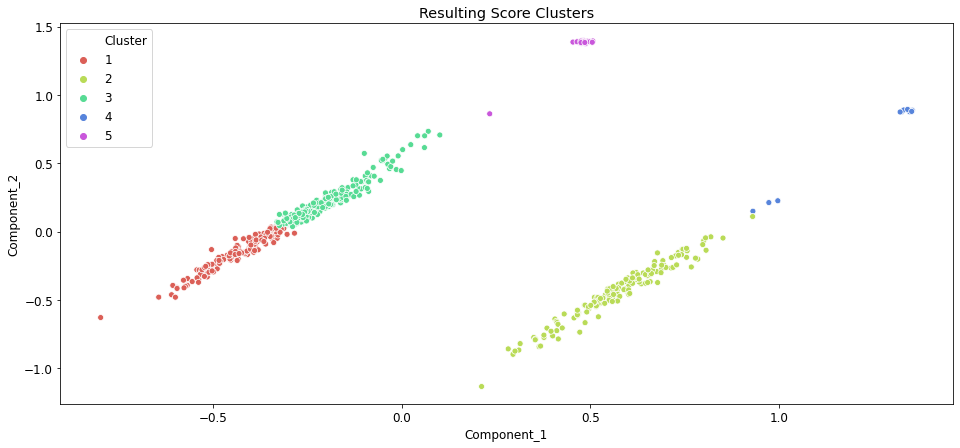

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,1.0,0.0
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,1.0,0.0
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,2,0,1.0,0.0
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,2,0,1.0,0.0
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,2,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z927126,53.0,1.0,0.0,15.0,12.0,42.0,24.0,30.0,24.0,3.32,...,0.500000,0.827273,1.500000,3.791667,-24.0,7.583333,2,1,NaN,NaN
Z928524,51.0,1.0,0.0,25.0,21.0,62.0,32.0,42.0,24.0,2.38,...,0.875000,0.427481,1.428571,2.333333,37.0,2.666667,0,1,NaN,NaN
Z93161,71.0,1.0,0.0,25.0,NaN,28.0,17.0,21.0,14.0,2.84,...,NaN,0.701031,NaN,4.857143,46.0,NaN,2,1,NaN,NaN
Z96296,70.0,2.0,0.0,65.0,4.0,31.0,11.0,18.0,7.0,2.32,...,0.571429,0.433071,5.000000,7.857143,45.0,13.750000,1,1,NaN,NaN


In [10]:
hemoDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=hemoOrig, labels=hemoLabels, 
                                    modelName=hemoModelName, columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
hemoDF

In [11]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [0, 3, 4, 2, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.363636,3,0.603306,5,0.190083,4,4.000000
1,0.348684,2,0.551020,3,0.142857,1,2.000000
2,0.297674,1,0.559006,4,0.155280,2,2.333333
3,0.416667,5,0.500000,2,0.166667,3,3.333333
4,0.384615,4,0.423077,1,0.230769,5,3.333333


In [12]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[5, 1, 2, 4, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.363636,3,0.603306,5,0.190083,4,4.000000,5
1,0.348684,2,0.551020,3,0.142857,1,2.000000,1
2,0.297674,1,0.559006,4,0.155280,2,2.333333,2
3,0.416667,5,0.500000,2,0.166667,3,3.333333,4
4,0.384615,4,0.423077,1,0.230769,5,3.333333,3


In [13]:
#Save separate datasets
escIndx = sorted(list(set(escapeHemo.index)))
escH = hemoDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AC_Hemo.csv")
escH

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,2,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,2,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,2,1,4,2
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,2,1,4,2
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,3,4,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,5,3,5,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,5,3,5,4
99935,64.0,2.0,1.0,20.0,8.0,49.0,29.0,31.0,15.0,4.00,...,0.533333,1.253333,2.500000,6.266667,30.0,11.750000,1,2,3,1


In [14]:
shockIndx = sorted(list(set(cardShockHemo.index)))
csH = hemoDF.loc[shockIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AC_Hemo.csv")
csH

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
Z1017923,62.0,1.0,0.0,20.0,9.0,38.0,20.0,26.0,15.0,4.83,...,0.600000,0.276786,2.000000,2.066667,56.0,3.444444,2,1,4,2
Z1024990,59.0,1.0,0.0,15.0,12.0,51.0,33.0,39.0,31.0,6.30,...,0.387097,0.752688,1.500000,2.258065,25.0,5.833333,5,3,5,4
Z1099417,37.0,2.0,0.0,25.0,32.0,58.0,34.0,44.0,21.0,3.39,...,1.523810,0.488095,0.750000,1.952381,30.0,1.281250,1,2,3,1
Z1140320,61.0,2.0,0.0,25.0,19.0,54.0,24.0,38.0,36.0,4.20,...,0.527778,0.172093,1.578947,1.027778,32.0,1.947368,1,2,3,1
Z114276,70.0,1.0,0.0,50.0,4.0,24.0,8.0,15.0,7.0,4.62,...,0.571429,0.292683,4.000000,5.142857,55.0,9.000000,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z927126,53.0,1.0,0.0,15.0,12.0,42.0,24.0,30.0,24.0,3.32,...,0.500000,0.827273,1.500000,3.791667,-24.0,7.583333,2,1,4,2
Z928524,51.0,1.0,0.0,25.0,21.0,62.0,32.0,42.0,24.0,2.38,...,0.875000,0.427481,1.428571,2.333333,37.0,2.666667,5,3,5,4
Z93161,71.0,1.0,0.0,25.0,NaN,28.0,17.0,21.0,14.0,2.84,...,NaN,0.701031,NaN,4.857143,46.0,NaN,2,1,4,2
Z96296,70.0,2.0,0.0,65.0,4.0,31.0,11.0,18.0,7.0,2.32,...,0.571429,0.433071,5.000000,7.857143,45.0,13.750000,1,2,3,1


# ALL DATA

In [15]:
# first - try other clustering methods
allD = copy.deepcopy(allDataOrig)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

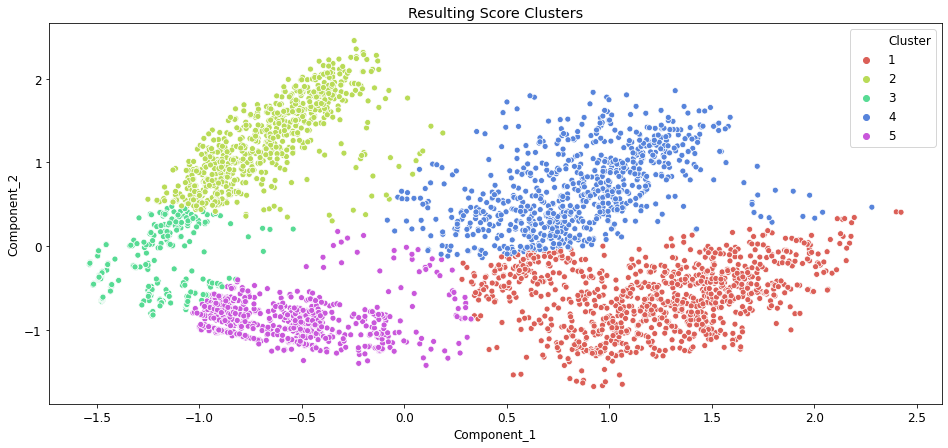

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,0,1,1.0,0.0
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,0,1,1.0,0.0
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,0,0,1.0,0.0
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,0,0,1.0,0.0
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z977261,47.0,2.0,0.0,0.000000,NaN,NaN,7.0,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,2,1,NaN,NaN
Z977261,47.0,2.0,0.0,0.000000,NaN,NaN,7.0,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,2,1,NaN,NaN
Z988224,19.0,1.0,0.0,0.000000,23.000000,39.0,48.0,0.0,0.0,0.0,...,0.0,0.000000,172.000000,42.0,0.350000,0.355932,4,0,NaN,NaN
Z988224,19.0,1.0,0.0,0.000000,NaN,4.0,48.0,0.0,0.0,0.0,...,0.0,0.000000,151.666667,45.0,0.412844,0.340909,4,0,NaN,NaN


In [16]:
allDataDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=allDataOrig, labels=allDataLabels, 
                                    modelName=allDataModelName, columns=['MAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [17]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [0, 3, 4, 2, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.238445,3,0.530462,5,0.18750,5,4.333333
1,0.189840,1,0.450535,3,0.00000,1,1.666667
2,0.414861,4,0.215385,2,0.00000,2,2.666667
3,0.207031,2,0.453125,4,0.16129,4,3.333333
4,0.532974,5,0.214286,1,0.12500,3,3.000000


In [18]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[5, 1, 2, 4, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.238445,3,0.530462,5,0.18750,5,4.333333,5
1,0.189840,1,0.450535,3,0.00000,1,1.666667,1
2,0.414861,4,0.215385,2,0.00000,2,2.666667,2
3,0.207031,2,0.453125,4,0.16129,4,3.333333,4
4,0.532974,5,0.214286,1,0.12500,3,3.000000,3


In [19]:
#Save separate datasets
escIndx = sorted(list(set(escapeAllData.index)))
escH = allDataDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AC_AllData.csv")
escH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,5,3,5,5
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,5,3,5,5
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,5,3,5,5
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,5,3,5,5
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,5,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,5,3,5,5
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,5,3,5,5
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,5,3,5,5
99935,64.0,2.0,1.0,77.700000,32.762692,3.0,16.0,3.0,101.0,0.0,...,86.0,NaN,135.333333,42.0,0.428571,0.488372,5,3,5,5


In [20]:
guIndx = sorted(list(set(guideAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AC_AllData.csv")
guH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
g10069,74.0,1.0,1.0,71.214733,26.948881,0.0,10.0,3.0,0.0,1.0,...,0.0,0.0,193.666667,37.0,0.282443,0.415730,4,2,4,4
g10069,74.0,1.0,1.0,NaN,0.000000,0.0,10.0,NaN,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,1,1,3,1
g10110,73.0,2.0,1.0,68.039554,22.807331,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,173.333333,40.0,0.333333,0.500000,4,2,4,4
g10110,73.0,2.0,1.0,NaN,0.000000,0.0,0.0,NaN,0.0,1.0,...,0.0,0.0,NaN,NaN,NaN,NaN,1,1,3,1
g10125,40.0,1.0,2.0,117.935226,NaN,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,200.666667,59.0,0.409722,0.655556,4,2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
g99676,74.0,1.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,1,1,3,1
g99887,60.0,2.0,2.0,76.204300,24.105394,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,190.666667,44.0,0.333333,0.463158,4,2,4,4
g99887,60.0,2.0,2.0,NaN,0.000000,0.0,0.0,NaN,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,1,1,3,1
g99955,61.0,1.0,1.0,81.700000,33.145361,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,156.666667,40.0,0.363636,0.439560,4,2,4,4


In [21]:
csIndx = sorted(list(set(cardShockAllData.index)))
csH = allDataDF.loc[escIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AC_AllData.csv")
csH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,5,3,5,5
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,5,3,5,5
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,5,3,5,5
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,5,3,5,5
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,5,3,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,5,3,5,5
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,5,3,5,5
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,5,3,5,5
99935,64.0,2.0,1.0,77.700000,32.762692,3.0,16.0,3.0,101.0,0.0,...,86.0,NaN,135.333333,42.0,0.428571,0.488372,5,3,5,5
